In [6]:
import cnn
from cnn import CNN
import torchvision
import torchvision.transforms as transforms
from cnn import load_data
from cnn import load_model_weights
from torchvision.models import efficientnet_b3, EfficientNet_B0_Weights,  EfficientNet_B4_Weights,EfficientNet_B3_Weights
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from tempfile import TemporaryDirectory
import os
import wandb

In [ ]:
# Load data and model 
train_dir = './dataset/training'
valid_dir = './dataset/validation'
unfreezed_layers = 2

train_loader, valid_loader, num_classes = load_data(train_dir, 
                                                    valid_dir, 
                                                    batch_size=32, 
                                                    img_size=300) # Efficient_Net requires 224x224 images
model = torchvision.models.efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)


# Freeze all parameters in the base model
for param in model.parameters():
    param.requires_grad = False

#  unfreeze the last few layers for fine-tuning.
if unfreezed_layers > 0:
    # EfficientNet's convolutional body is stored in base_model.features 
    features = list(model.features.children())
    for layer in features[-unfreezed_layers:]:
        for param in layer.parameters():
            param.requires_grad = True

device = torch.device("cpu")
model.classifier =  nn.Sequential(
            nn.Dropout(0.3, inplace=True),
            nn.Linear(1536, num_classes,bias=True),
        )
model.to(device)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [8]:
trainable_layers = [param for param in model.parameters() if param.requires_grad]
trainable_layers

[Parameter containing:
 tensor([[[[ 0.1015]],
 
          [[-0.1278]],
 
          [[-0.0576]],
 
          ...,
 
          [[-0.0125]],
 
          [[-0.0544]],
 
          [[ 0.0270]]],
 
 
         [[[ 0.1341]],
 
          [[-0.0226]],
 
          [[-0.1436]],
 
          ...,
 
          [[-0.0621]],
 
          [[ 0.1272]],
 
          [[-0.0189]]],
 
 
         [[[ 0.0026]],
 
          [[-0.0755]],
 
          [[ 0.0783]],
 
          ...,
 
          [[-0.0465]],
 
          [[ 0.0928]],
 
          [[ 0.0475]]],
 
 
         ...,
 
 
         [[[-0.0534]],
 
          [[ 0.0845]],
 
          [[-0.0769]],
 
          ...,
 
          [[ 0.1617]],
 
          [[-0.0426]],
 
          [[-0.0490]]],
 
 
         [[[ 0.0312]],
 
          [[-0.0248]],
 
          [[ 0.0262]],
 
          ...,
 
          [[ 0.1364]],
 
          [[-0.1960]],
 
          [[ 0.1100]]],
 
 
         [[[ 0.0778]],
 
          [[-0.1125]],
 
          [[ 0.0597]],
 
          ...,
 
          [[-0.04

In [9]:
def load_data(train_dir, valid_dir, batch_size, img_size):
    """Load and transform the training and validation datasets.

    Args:
        train_dir: Path to the training dataset.
        valid_dir: Path to the validation dataset.
        batch_size: Number of images per batch.
        img_size: Expected size of the images.

    Returns:
        train_loader: DataLoader with the training dataset.
        valid_loader: DataLoader with the validation dataset.
        num_classes: Number of classes in the dataset.
    """
 
    train_transforms = transforms.Compose([
        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
        transforms.RandomRotation(30), # Rotate the image by a random angle
        transforms.RandomResizedCrop(img_size), # Crop the image to a random size and aspect ratio
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(), # Horizontally flip the image with a 50% probability
        transforms.ToTensor() 
    ])

   
    valid_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor() 
    ])

    train_data = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
    valid_data = torchvision.datasets.ImageFolder(valid_dir, transform=valid_transforms)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, len(train_data.classes)

In [10]:

def train_model(model, 
                train_loader, 
                valid_loader, 
                optimizer, 
                criterion,
                run,  
                epochs,
                nepochs_to_save=10):
    """Train the model and save the best one based on validation accuracy.
    
    Args:
        train_loader: DataLoader with training data.
        valid_loader: DataLoader with validation data.
        optimizer: Optimizer to use during training.
        criterion: Loss function to use during training.
        epochs: Number of epochs to train the model.
        nepochs_to_save: Number of epochs to wait before saving the model.

    Returns:
        history: A dictionary with the training history.
    """
    with TemporaryDirectory() as temp_dir:
        best_model_path = os.path.join(temp_dir, 'best_model.pt')
        best_accuracy = 0.0
        torch.save(model.state_dict(), best_model_path)

        history = {'train_loss': [], 'train_accuracy': [], 'valid_loss': [], 'valid_accuracy': []}
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            train_accuracy = 0.0
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_accuracy += (outputs.argmax(1) == labels).sum().item()

            train_loss /= len(train_loader)
            train_accuracy /= len(train_loader.dataset)
            history['train_loss'].append(train_loss)
            history['train_accuracy'].append(train_accuracy)

            print(f'Epoch {epoch + 1}/{epochs} - '
                    f'Train Loss: {train_loss:.4f}, '
                    f'Train Accuracy: {train_accuracy:.4f}')
            
            
            model.eval()
            valid_loss = 0.0
            valid_accuracy = 0.0
            for images, labels in valid_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                valid_accuracy += (outputs.argmax(1) == labels).sum().item()
               
            valid_loss /= len(valid_loader)
            valid_accuracy /= len(valid_loader.dataset)
            history['valid_loss'].append(valid_loss)
            history['valid_accuracy'].append(valid_accuracy)

            print(f'Epoch {epoch + 1}/{epochs} - '
                    f'Validation Loss: {valid_loss:.4f}, '
                    f'Validation Accuracy: {valid_accuracy:.4f}')
            
            if epoch % nepochs_to_save == 0:
                if valid_accuracy > best_accuracy:
                    best_accuracy = valid_accuracy
                    torch.save(model.state_dict(), best_model_path)
            run.log({"tr_acc": train_accuracy,"tr_loss": train_loss,"val_acc": valid_accuracy, "val_loss": valid_loss})
            
        torch.save(model.state_dict(), best_model_path)    
        model.load_state_dict(torch.load(best_model_path))
        return history

In [ ]:
import random


# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="202410994-universidad-pontificia-comillas",
    name = "Efficient-b3_last_try",
    # Set the wandb project where this run will be logged.
    project="Practica_ML2",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.0008,
        "architecture": "EfficientNet-b3",
        "dataset": "custom",
        "epochs": 5,
    
        
    }
)

optimizer = torch.optim.Adam(model.parameters(), lr=8e-4)
criterion = nn.CrossEntropyLoss()
history = train_model(model,train_loader, valid_loader, optimizer, criterion,run, epochs=5)

run.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 202410994 (202410994-universidad-pontificia-comillas) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/5 - Train Loss: 1.4530, Train Accuracy: 0.5896
Epoch 1/5 - Validation Loss: 16.2761, Validation Accuracy: 0.8307
Epoch 2/5 - Train Loss: 0.7667, Train Accuracy: 0.7534
Epoch 2/5 - Validation Loss: 17.7875, Validation Accuracy: 0.8867
Epoch 3/5 - Train Loss: 0.6543, Train Accuracy: 0.7856
Epoch 3/5 - Validation Loss: 21.5664, Validation Accuracy: 0.8940
Epoch 4/5 - Train Loss: 0.5976, Train Accuracy: 0.8117
Epoch 4/5 - Validation Loss: 14.8997, Validation Accuracy: 0.8873
Epoch 5/5 - Train Loss: 0.5608, Train Accuracy: 0.8131
Epoch 5/5 - Validation Loss: 20.5963, Validation Accuracy: 0.8953


tr_acc,▁▆▇██
tr_loss,█▃▂▁▁
val_acc,▁▇█▇█
val_loss,▂▄█▁▇
tr_acc,0.81307
tr_loss,0.56079
val_acc,0.89533
val_loss,20.59628


In [13]:
def predict(model, data_loader):
    """Predict the classes of the images in the data loader.

    Args:
        data_loader: DataLoader with the images to predict.

    Returns:
        predicted_labels: Predicted classes.
    """
    model.eval()
    predicted_labels = []
    for images, _ in data_loader:
        outputs = model(images)
        predicted_labels.extend(outputs.argmax(1).tolist())
    return predicted_labels
        
def save_model(model, filename: str):
    """Save the model to disk.

    Args:
        filename: Name of the file to save the model.
    """
    # If the directory does not exist, create it
    os.makedirs(os.path.dirname('models/'), exist_ok=True)

    # Full path to the model
    filename = os.path.join('models', filename)

    # Save the model
    torch.save(model.state_dict(), filename+'.pt')

@staticmethod
def _plot_training(history):
    """Plot the training history.

    Args:
        history: A dictionary with the training history.
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['valid_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['valid_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [14]:
def load_model_weights(filename: str):
        """Load a model from disk.
        IMPORTANT: The model must be initialized before loading the weights.
        Args:
            filename: Name of the file to load the model.
        """
        # Full path to the model
        filename = os.path.join('models', filename)

        # Load the model
        state_dict = torch.load(filename+'.pt')
        return state_dict

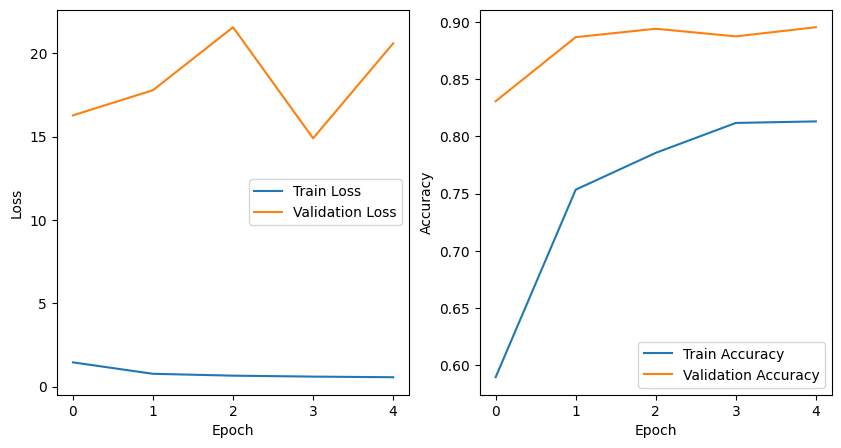

In [15]:
_plot_training(history)
save_model(model,"EfficientNet-B3_v4")

<>:37: SyntaxWarning: invalid escape sequence '\P'
<>:37: SyntaxWarning: invalid escape sequence '\P'
C:\Users\jpcha\AppData\Local\Temp\ipykernel_26164\3060169656.py:37: SyntaxWarning: invalid escape sequence '\P'
  test_data_dir = "C:\\Users\\jpcha\\MasterICAI\\ML2\\Practicas_DeepLearning_2025\\repoGit\\Practica_ML2\\agascong\Practicas_DeepLearning_chavez\\03TransferLearning\\dataset\\validation"      # Update with the path to your test data.


Classification Report:
                precision    recall  f1-score   support

      Bedroom       0.95      0.71      0.81       100
        Coast       0.88      0.93      0.90       100
       Forest       0.93      0.87      0.90       100
      Highway       0.95      0.95      0.95       100
   Industrial       0.95      0.90      0.92       100
  Inside City       0.89      0.84      0.87       100
      Kitchen       0.91      0.94      0.93       100
  Living room       0.77      0.97      0.86       100
     Mountain       0.93      0.87      0.90       100
       Office       0.95      0.92      0.93       100
 Open country       0.82      0.81      0.81       100
        store       0.89      0.97      0.93       100
       Street       0.88      0.97      0.92       100
       Suburb       0.98      1.00      0.99       100
Tall building       0.95      0.91      0.93       100

     accuracy                           0.90      1500
    macro avg       0.91      0.90     

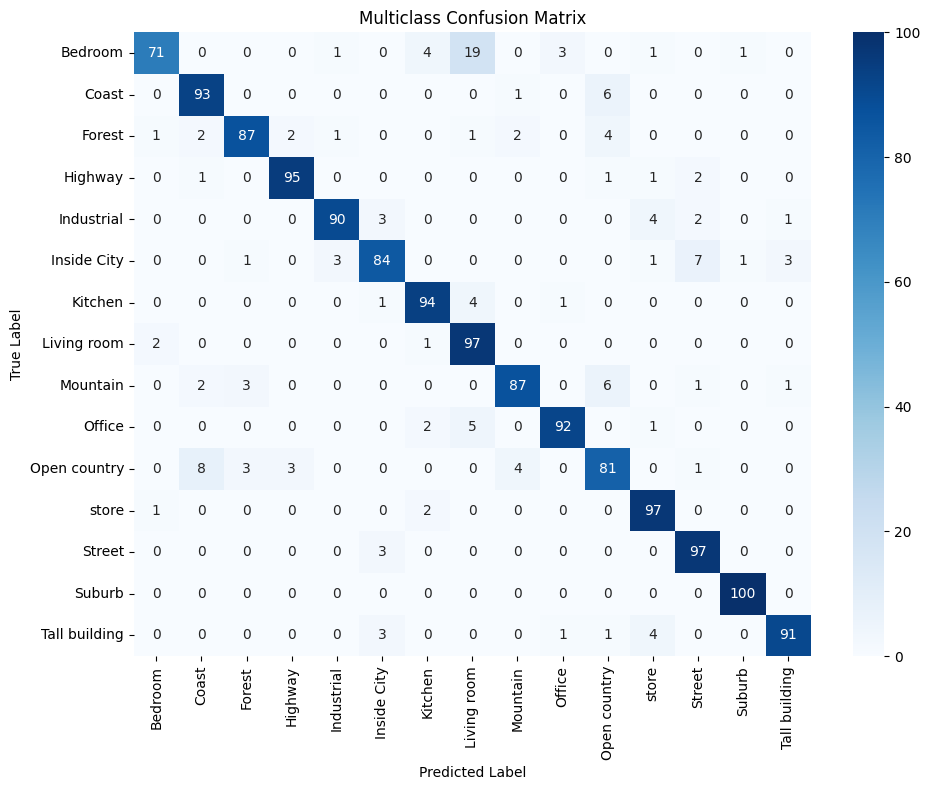

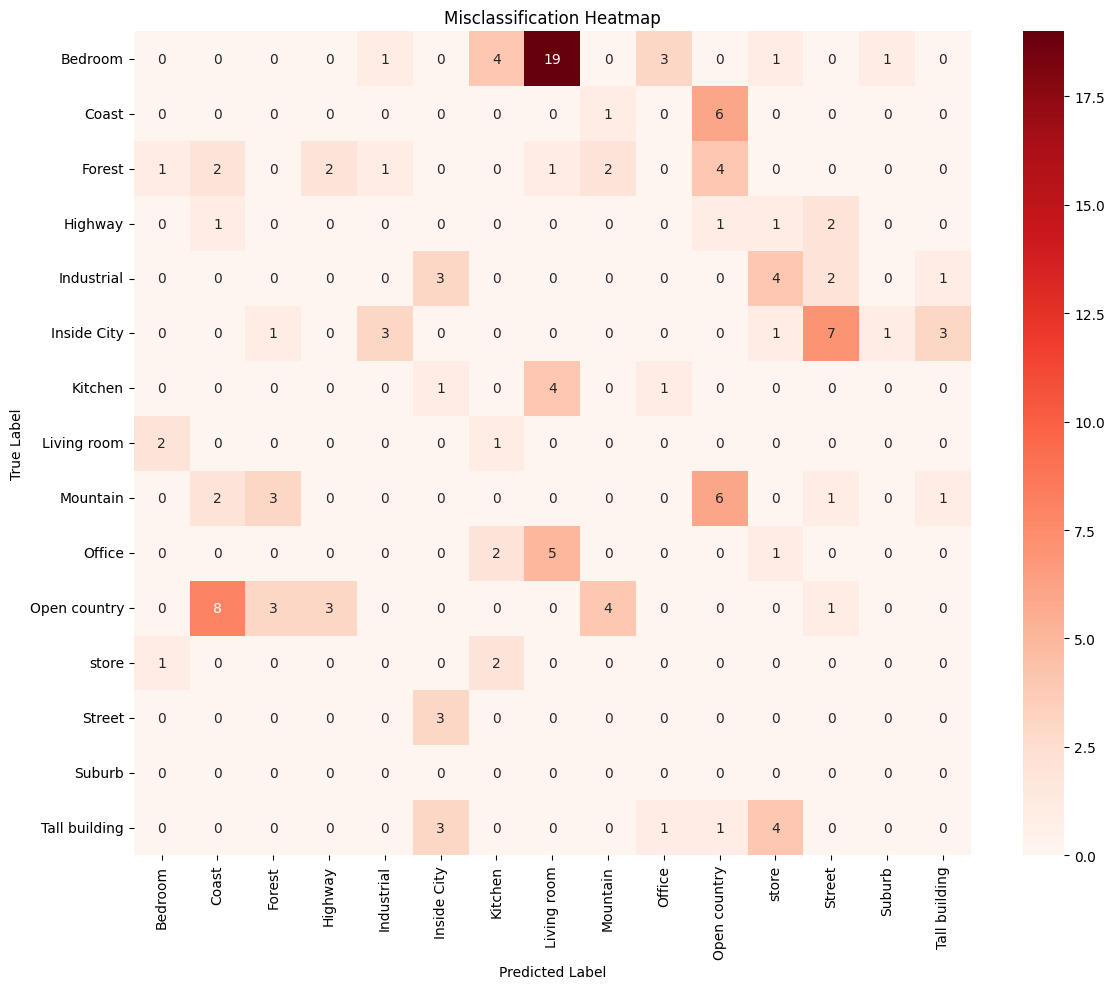

In [20]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Number of classes in your model.
NUM_CLASSES = 15

# Define your class names in the correct order.
class_names = [
    "Bedroom", "Coast", "Forest", "Highway", "Industrial",
    "Inside City", "Kitchen", "Living room", "Mountain", "Office",
    "Open country", "store", "Street", "Suburb", "Tall building"
]

def load_model(model_path):
    """Load the EfficientNet B3 model with a custom classifier."""
    model = models.efficientnet_b3()
    model.classifier = nn.Sequential(
        nn.Dropout(0.5, inplace=True),
        nn.Linear(1536, NUM_CLASSES, bias=True),
    )
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    model.eval()
    return model

def main():
    # Paths to your model file and test data.
    model_path = "C:\\Users\\jpcha\\MasterICAI\\ML2\\Practicas_DeepLearning_2025\\repoGit\\Practica_ML2\\agascong\\Practicas_DeepLearning_chavez\\03TransferLearning\\models\\EfficientNet-B3_v2.pt"        # Update with the correct model path.
    test_data_dir = "C:\\Users\\jpcha\\MasterICAI\\ML2\\Practicas_DeepLearning_2025\\repoGit\\Practica_ML2\\agascong\Practicas_DeepLearning_chavez\\03TransferLearning\\dataset\\validation"      # Update with the path to your test data.

    # Load the pretrained model.
    model = load_model(model_path)
    
    # Define transforms. These should match those used during training.
    transform = transforms.Compose([
        transforms.Resize(300),
        transforms.CenterCrop(300),
        transforms.ToTensor(),
        # Uncomment and adjust if normalization was used during training:
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                      std=[0.229, 0.224, 0.225]),
    ])
    
    # Load the test dataset (expects subfolders per class).
    test_dataset = datasets.ImageFolder(test_data_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    all_labels = []
    all_preds = []

    # Evaluate the model on the test dataset.
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, preds = torch.max(probabilities, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute the confusion matrix.
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("Classification Report:\n", report)

    # Plot the multiclass confusion matrix.
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Multiclass Confusion Matrix")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    plt.show()

       # Create a misclassification matrix by zeroing out the diagonal.
    misclassified_cm = cm.copy()
    np.fill_diagonal(misclassified_cm, 0)

    # Plot the misclassification heatmap.
    plt.figure(figsize=(12, 10))
    sns.heatmap(misclassified_cm, annot=True, fmt='d', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Misclassification Heatmap")
    plt.tight_layout()
    plt.savefig("missclassification_matrix.png")
    plt.show()

if __name__ == "__main__":
    main()



In [ ]:
predicted_labels = predict(model, valid_loader)